In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from haversine import haversine

In [2]:
filename='trace4'
path=r'../data/drive-me-not/processed/'
output_path=r'../outputs/png/'+filename
if not os.path.exists(output_path):
    os.mkdir(output_path) 
full_filename='spoofed_'+filename+'_unique_cell.csv'
data=pd.read_csv(path+full_filename) 
data=data[['Time','GPS_lat','GPS_long','lat','lon','spoofed']]
print(data)

               Time    GPS_lat   GPS_long        lat        lon  spoofed
0     1561285791859  25.368868  51.551123  25.369492  51.550598      0.0
1     1561285791859  25.368868  51.551123  25.367661  51.550369      0.0
2     1561285791859  25.368868  51.551123  25.368256  51.557053      0.0
3     1561285791859  25.368868  51.551123  25.366287  51.551102      0.0
4     1561285791859  25.368868  51.551123  25.368494  51.552817      0.0
...             ...        ...        ...        ...        ...      ...
5859  1561287660910  25.386922  51.446212  25.304204  51.513501      1.0
5860  1561287660910  25.386922  51.446212  25.313736  51.517776      1.0
5861  1561287660910  25.386922  51.446212  25.317307  51.520615      1.0
5862  1561287660910  25.386922  51.446212  25.317536  51.527775      1.0
5863  1561287660910  25.386922  51.446212  25.291443  51.530685      1.0

[5864 rows x 6 columns]


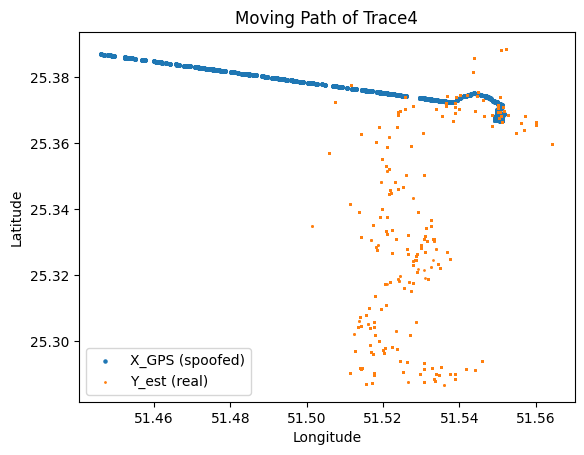

In [3]:
plt.scatter(data['GPS_long'], data['GPS_lat'],s=5,label='X_GPS (spoofed)')
plt.scatter(data['lon'], data['lat'],s=1,label='Y_est (real)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Moving Path of T'+filename[1:])
plt.legend()
plt.savefig(output_path+'/Garrett_moving_path')
plt.show()
plt.close()

In [4]:
#Garrett's first method
data['d_e']=data.apply(lambda row: haversine((row['GPS_lat'],row['GPS_long']),(row['lat'],row['lon'])), axis=1)
#Calculate the impact of different thresholds.
threshold=np.arange(0.5,8,0.2,dtype=float)
for th in threshold:
    name='th_'+str(th)
    data[name]=data.apply(lambda row: row['d_e']>th, axis=1)
print(data)

               Time    GPS_lat   GPS_long        lat        lon  spoofed  \
0     1561285791859  25.368868  51.551123  25.369492  51.550598      0.0   
1     1561285791859  25.368868  51.551123  25.367661  51.550369      0.0   
2     1561285791859  25.368868  51.551123  25.368256  51.557053      0.0   
3     1561285791859  25.368868  51.551123  25.366287  51.551102      0.0   
4     1561285791859  25.368868  51.551123  25.368494  51.552817      0.0   
...             ...        ...        ...        ...        ...      ...   
5859  1561287660910  25.386922  51.446212  25.304204  51.513501      1.0   
5860  1561287660910  25.386922  51.446212  25.313736  51.517776      1.0   
5861  1561287660910  25.386922  51.446212  25.317307  51.520615      1.0   
5862  1561287660910  25.386922  51.446212  25.317536  51.527775      1.0   
5863  1561287660910  25.386922  51.446212  25.291443  51.530685      1.0   

            d_e  th_0.5  th_0.7  th_0.8999999999999999  ...  \
0      0.087150   False 

In [5]:
def all_is_true(x):
    for i in x:
        if i==False:
            return False
    return True

#Calculate the impact of different bursts length.
burst_length=np.arange(1,15,1,dtype=int)
attack_start_id=np.where(data['spoofed']==1)[0][0]
attack_start_time=data['Time'][attack_start_id]

#An empty 2d data frame to store the result of FP. rows: burst_length, columns: threshold 
fp_data=pd.DataFrame(columns=threshold)
#An empty 2d data frame to store the result of time to detect.
detect_time_data=pd.DataFrame(columns=threshold)

for th in threshold:
    name='th_'+str(th)
    fp_arr=np.array([])
    detect_time_arr=np.array([])

    for bl in burst_length:
        num_fp=0
        detect_time=data['Time'][data.shape[0]-1]-attack_start_time

        for i in range(data.shape[0]-bl+1):
            if all_is_true(data[name][i:i+bl]):
                if i<=attack_start_id:
                    num_fp=num_fp+1
                else:
                    detect_time=data['Time'][i+bl-1]-attack_start_time
                    break
        fp_rate=num_fp/attack_start_id
        fp_arr=np.append(fp_arr,fp_rate)
        detect_time=detect_time/1000 #change ms to s
        detect_time_arr=np.append(detect_time_arr,detect_time)

    fp_data[th]=fp_arr
    detect_time_data[th]=detect_time_arr

print(fp_data)

         0.5       0.7       0.9       1.1       1.3       1.5       1.7  \
0   0.556439  0.424165  0.362798  0.314149  0.300159  0.284261  0.256598   
1   0.308108  0.195866  0.117011  0.090620  0.086486  0.085215  0.073132   
2   0.172019  0.085533  0.017488  0.012083  0.011129  0.011129  0.011129   
3   0.091256  0.029571  0.000000  0.000000  0.000000  0.000000  0.000000   
4   0.040700  0.006677  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.018124  0.000954  0.000000  0.000000  0.000000  0.000000  0.000000   
6   0.006041  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7   0.002544  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
10  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
11  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
12  0.000000

In [6]:
print(detect_time_data)

        0.5      0.7      0.9      1.1      1.3      1.5      1.7      1.9  \
0     0.000    0.000    0.000    0.000    0.000    0.000    0.000   40.523   
1     0.000    0.000    0.000    0.000    0.000   80.502   80.502   80.502   
2     0.000    1.022   55.887   55.887   82.634  132.787  157.348  157.348   
3     0.000   20.707   87.969  105.257  105.257  157.348  157.348  157.348   
4    55.887   87.969   87.969  157.348  157.348  157.348  157.348  157.348   
5    87.969   87.969   87.969  157.348  157.348  157.348  157.348  157.348   
6    87.969   87.969   87.969  157.348  157.348  157.348  172.653  224.001   
7    97.889  105.953  123.230  166.673  224.001  224.001  224.001  224.001   
8    97.889  105.953  123.546  172.653  224.001  224.001  224.001  224.001   
9    97.889  105.953  172.653  172.653  224.001  224.001  224.001  224.001   
10   97.889  123.546  224.001  224.001  224.001  224.001  224.001  224.001   
11  123.546  224.001  224.001  224.001  224.001  224.001  224.00

C:\Users\liu\AppData\Local\Temp\ipykernel_1088\2750859828.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(title=filename)


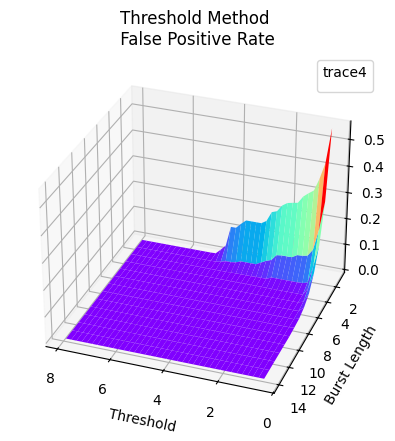

In [7]:
fig = plt.figure()
ax3 = plt.axes(projection='3d')

X, Y = np.meshgrid(threshold, burst_length)
Z = fp_data

ax3.plot_surface(X,Y,Z,rstride = 1, cstride = 1, cmap='rainbow')
ax3.view_init(30, 110)

ax3.set_xlabel('Threshold')
ax3.set_ylabel('Burst Length')
ax3.set_zlabel('')
ax3.legend(title=filename)
plt.title('Threshold Method\n False Positive Rate')
plt.savefig(output_path+'/Garrett_FP_rate')
plt.show()
plt.close(fig)


C:\Users\liu\AppData\Local\Temp\ipykernel_1088\3033085937.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(title=filename)


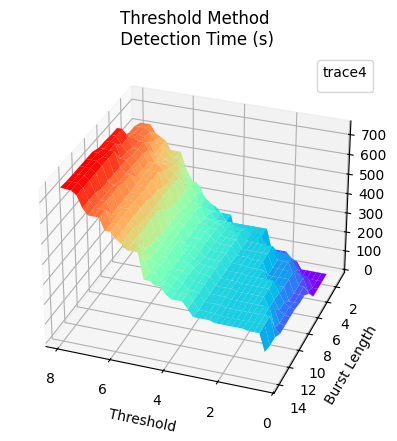

In [8]:
fig = plt.figure()
ax3 = plt.axes(projection='3d')

X, Y = np.meshgrid(threshold, burst_length)
Z = detect_time_data

ax3.plot_surface(X,Y,Z,rstride = 1, cstride = 1, cmap='rainbow')
ax3.view_init(30,110)

ax3.set_xlabel('Threshold')
ax3.set_ylabel('Burst Length')
ax3.set_zlabel('')
ax3.legend(title=filename)
plt.title('Threshold Method\n Detection Time (s)')
plt.savefig(output_path+'/Garrett_detection_time')
plt.show()
plt.close(fig)

C:\Users\liu\AppData\Local\Temp\ipykernel_1088\1364428401.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(title=filename)


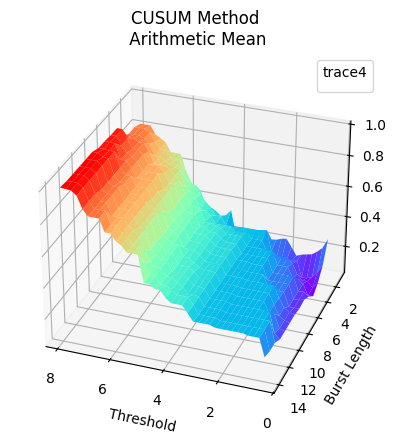

Recommended parameter values:

threshold of Threshold method:  0.7
burst length of Threshold method:  3
FP rate of Threshold method:  0.029570747217806042
detection time of Threshold method:  21.007


In [9]:
detect_time_norm=(detect_time_data-detect_time_data.stack().min())/(detect_time_data.stack().max()-detect_time_data.stack().min())
arith_mean=detect_time_norm+fp_data/2

fig = plt.figure()
ax3 = plt.axes(projection='3d')

X, Y = np.meshgrid(threshold, burst_length)
Z = arith_mean

ax3.plot_surface(X,Y,Z,rstride = 1, cstride = 1, cmap='rainbow')
ax3.view_init(30,110)

ax3.set_xlabel('Threshold')
ax3.set_ylabel('Burst Length')
ax3.set_zlabel('')
ax3.legend(title=filename)
plt.title('CUSUM Method\n Arithmetic Mean')
plt.savefig(output_path+'/Garrett_detection_arithmetic_mean')
plt.show()
plt.close(fig)

c,r=arith_mean.stack().idxmin()
print("Recommended parameter values:\n")
print("threshold of Threshold method: ",r)
print("burst length of Threshold method: ",c)
print("FP rate of Threshold method: ",fp_data[r][c])
print("detection time of Threshold method: ",detect_time_data[r][c]+c/10)

In [10]:
#Garrett's CUSUM method
threshold=np.arange(0,12,0.2,dtype=float)
weight=np.arange(0.5,7,0.2,dtype=float)

#An empty 2d data frame to store the result of FP. rows: weight, columns: threshold 
fp_data=pd.DataFrame(columns=threshold)
#An empty 2d data frame to store the result of time to detect.
detect_time_data=pd.DataFrame(columns=threshold)

for th in threshold:
    name='d_e'
    fp_arr=np.array([])
    detect_time_arr=np.array([])

    for w in weight:
        num_fp=0
        detect_time=data['Time'][data.shape[0]-1]-attack_start_time
        
        s=0
        for i in range(data.shape[0]):
            s=max(0,s+data[name][i]-w)
            if s>th:
                if i<=attack_start_id:
                    num_fp=num_fp+1
                else:
                    detect_time=data['Time'][i]-attack_start_time
                    break
        fp_rate=num_fp/attack_start_id
        fp_arr=np.append(fp_arr,fp_rate)
        detect_time=detect_time/1000 #change ms to s
        detect_time_arr=np.append(detect_time_arr,detect_time)

    fp_data[th]=fp_arr
    detect_time_data[th]=detect_time_arr

print(fp_data)

        0.0       0.2       0.4       0.6       0.8       1.0       1.2   \
0   0.999046  0.998728  0.998728  0.998410  0.998410  0.998410  0.998410   
1   0.998728  0.998728  0.998410  0.998410  0.998410  0.998410  0.998092   
2   0.998728  0.998410  0.998410  0.998092  0.998092  0.998092  0.998092   
3   0.998410  0.990143  0.987599  0.987599  0.986645  0.986645  0.979014   
4   0.979650  0.977424  0.977424  0.973927  0.973609  0.968521  0.964070   
5   0.758029  0.738951  0.733545  0.717647  0.704293  0.702703  0.700795   
6   0.612719  0.584102  0.557075  0.540541  0.534499  0.515421  0.483625   
7   0.494118  0.484579  0.471542  0.465501  0.447695  0.407313  0.372019   
8   0.433068  0.419078  0.406995  0.395231  0.350715  0.311924  0.293800   
9   0.390779  0.378060  0.347536  0.281717  0.249603  0.243561  0.232432   
10  0.317647  0.282671  0.243561  0.225437  0.202544  0.194595  0.193005   
11  0.262957  0.213037  0.193323  0.188553  0.187599  0.182512  0.163434   
12  0.200636

In [11]:
print(detect_time_data)

       0.0      0.2      0.4      0.6      0.8      1.0      1.2      1.4   \
0     0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000   
1     0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000   
2     0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000   
3     0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000   
4     0.000    0.000    0.000    0.000    0.000    0.000    0.000    0.000   
5     0.000    0.000   40.523   80.502   80.502   80.502   80.502   80.502   
6     0.000   40.523   80.502   80.502   80.502   80.502   80.502   80.502   
7    40.523   80.502   80.502   80.502   80.502   80.502   80.502  105.257   
8    80.502   80.502   80.502   80.502   80.502  105.257  105.257  105.257   
9    80.502   80.502   80.502  105.257  105.257  105.257  105.257  105.257   
10   80.502   80.502  105.257  105.257  105.257  105.257  105.257  105.257   
11   80.502  105.257  105.257  105.257  105.257  105.257  105.25

C:\Users\liu\AppData\Local\Temp\ipykernel_1088\371324411.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(title=filename)


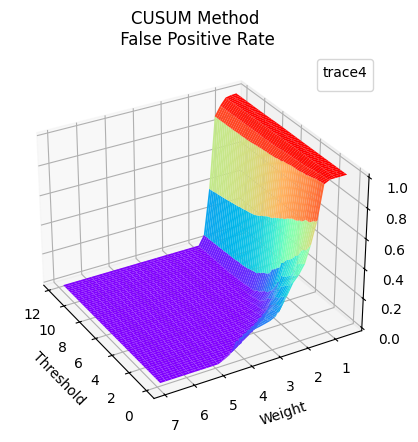

In [12]:
fig = plt.figure()
ax3 = plt.axes(projection='3d')

X, Y = np.meshgrid(threshold, weight)
Z = fp_data

ax3.plot_surface(X,Y,Z,rstride = 1, cstride = 1, cmap='rainbow')
ax3.view_init(30, 150)

ax3.set_xlabel('Threshold')
ax3.set_ylabel('Weight')
ax3.set_zlabel('')
ax3.legend(title=filename)
plt.title('CUSUM Method\n False Positive Rate')
plt.savefig(output_path+'/Garrett_FP_rate_CUSUM')
plt.show()
plt.close(fig)

C:\Users\liu\AppData\Local\Temp\ipykernel_1088\3800024093.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(title=filename)


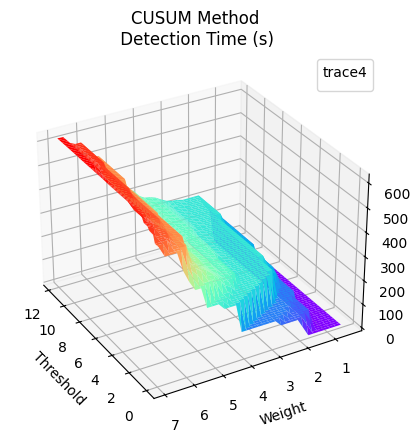

In [13]:
fig = plt.figure()
ax3 = plt.axes(projection='3d')

X, Y = np.meshgrid(threshold, weight)
Z = detect_time_data

ax3.plot_surface(X,Y,Z,rstride = 1, cstride = 1, cmap='rainbow')
ax3.view_init(30,150)

ax3.set_xlabel('Threshold')
ax3.set_ylabel('Weight')
ax3.set_zlabel('')
ax3.legend(title=filename)
plt.title('CUSUM Method\n Detection Time (s)')
plt.savefig(output_path+'/Garrett_detection_time_CUSUM')
plt.show()
plt.close(fig)
plt.close(fig)

C:\Users\liu\AppData\Local\Temp\ipykernel_1088\3481102724.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(title=filename)


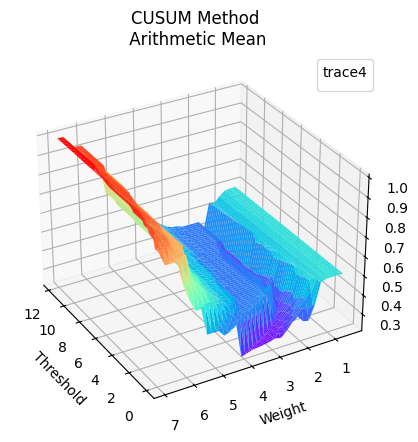

Recommended parameter values:

threshold of CUSUM method:  0.0
Weight of CUSUM method:  18
FP rate of CUSUM method:  0.11955484896661367
detection time of CUSUM method:  105.257


In [16]:
detect_time_norm=(detect_time_data-detect_time_data.stack().min())/(detect_time_data.stack().max()-detect_time_data.stack().min())
arith_mean=detect_time_norm+fp_data/2

fig = plt.figure()
ax3 = plt.axes(projection='3d')

X, Y = np.meshgrid(threshold, weight)
Z = arith_mean

ax3.plot_surface(X,Y,Z,rstride = 1, cstride = 1, cmap='rainbow')
ax3.view_init(30,150)

ax3.set_xlabel('Threshold')
ax3.set_ylabel('Weight')
ax3.set_zlabel('')
ax3.legend(title=filename)
plt.title('CUSUM Method\n Arithmetic Mean')
plt.savefig(output_path+'/Garrett_detection_CUSUM_arithmetic_mean')
plt.show()
plt.close(fig)

c,r=arith_mean.stack().idxmin()
print("Recommended parameter values:\n")
print("threshold of CUSUM method: ",r)
print("Weight of CUSUM method: ",c)
print("FP rate of CUSUM method: ",fp_data[r][c])
print("detection time of CUSUM method: ",detect_time_data[r][c])